<a href="https://colab.research.google.com/github/ReemAlsharabi/KAUST-Academy/blob/main/Adv/Day3/MNIST_VarAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Expectations: Please provide solutions to the questions in the cells at the end of the notebook.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [2]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    
    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader



In [3]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader=mnist(batch_sz) 

100%|██████████| 9912422/9912422 [00:00<00:00, 111762965.07it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24077856.06it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25290229.31it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7318681.82it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [16]:
class AE(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.nz = nz 
    self.elayer1 = nn.Linear(784, 500)
    self.ebn1 = nn.BatchNorm1d(500)
    self.elayer2 = nn.Linear(500, 200)
    self.ebn2 = nn.BatchNorm1d(200)
    self.elayer3 = nn.Linear(200, 20)
  
    self.dlayer1 = nn.Linear(20, 200)
    self.dbn1 = nn.BatchNorm1d(200)
    self.dlayer2 = nn.Linear(200, 400)
    self.dbn2 = nn.BatchNorm1d(400)
    self.dlayer3 = nn.Linear(400, 784)

  def encoder(self, x):
    x = self.elayer1(x)
    x = torch.relu(x)
    x = self.ebn1(x)

    x = self.elayer2(x)
    x = torch.relu(x)
    x = self.ebn2(x)

    x = self.elayer3(x)
    x = torch.sigmoid(x)

    return x
    

  def decoder(self, x):
    x = self.dlayer1(x)
    x = torch.relu(x)
    x = self.dbn1(x)

    x = self.dlayer2(x)
    x = torch.relu(x)
    x = self.dbn2(x)

    x = self.dlayer3(x)
    x = torch.sigmoid(x)

    return x

  def forward(self, x):
    z = self.encoder(x)
    x = self.decoder(z)

    return z, x

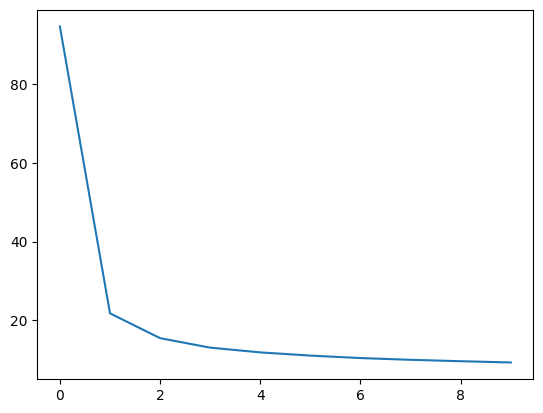

In [17]:
device = torch.device("cuda:0")
net = AE(10).to(device)
num_epochs = 10
lr = 1e-4
opt = optim.Adam(net.parameters(), lr = lr)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].to(device)
    X = X.view(-1, 784)
    Z, Xhat = net(X)
    loss = F.mse_loss(X, Xhat)
    total_loss+=loss.item()
    opt.zero_grad()
    loss.backward()
    opt.step()
  ls.append(total_loss)
plt.plot(ls)


In [18]:
X = X.detach().cpu()
Xhat = Xhat.detach().cpu()

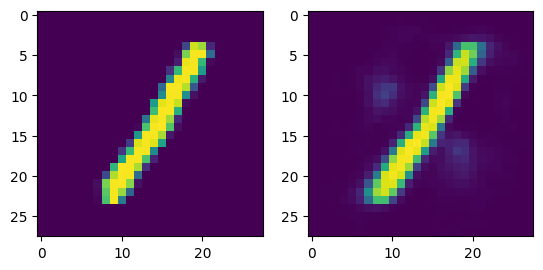

In [19]:
plt.subplot(121)
plt.imshow(X[0,:].reshape(28, 28))
plt.subplot(122)
plt.imshow(Xhat[0,:].reshape(28, 28))

CNN & AE

In [41]:
class AutoEncoderConv(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(1, 16, 3, 1, 1)
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear(64*7*7, 100)
    self.ebn4 = nn.BatchNorm1d(100)
    self.elinear2 = nn.Linear(100, self.nz)

    #self.plinear1 = nn.Linear(nz,nz)
    #self.plinear2 = nn.Linear(nz,nz)

    self.dlinear1 = nn.Linear(self.nz, 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.dlinear2 = nn.Linear(100, 64*7*7)
    self.dbn2 = nn.BatchNorm1d(64*7*7)
    self.dtconv1 = nn.ConvTranspose2d(64, 32, 3, 1, 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dtconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding= 1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dtconv3 = nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding= 1)

  def encoder(self, x):
    x = torch.relu(self.econv1(x))
    x = self.ebn1(x)

    x = torch.relu(self.econv2(x))
    x = self.ebn2(x)

    x = torch.relu(self.econv3(x))
    x = self.ebn3(x)

    x = x.view(-1, 64*7*7) # reshape because next layers are linear 

    x = torch.relu(self.elinear1(x))
    x = self.ebn4(x)

    x = torch.sigmoid(self.elinear2(x))
    return x

  def decoder(self, x):
    x = torch.relu(self.dlinear1(x))
    x = self.dbn1(x)

    x = torch.relu(self.dlinear2(x))
    x = self.dbn2(x)

    x = x.view(-1, 64, 7, 7) # making them images

    x = torch.relu(self.dtconv1(x))
    x = self.dbn3(x)

    x = torch.relu(self.dtconv2(x))
    x = self.dbn4(x)

    x = torch.sigmoid(self.dtconv3(x))

    return x

  def forward(self, x):
    z = self.encoder(x)
    x = self.decoder(z)

    return z, x

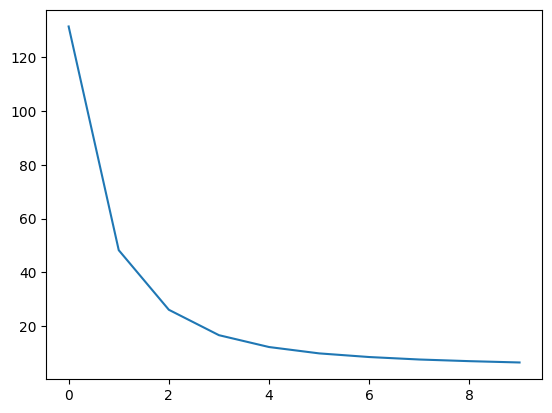

In [42]:
device = torch.device("cuda:0")
nz = 32
net = AutoEncoderConv(nz).to(device)
num_epochs = 10
lr = 1e-4
opt = optim.Adam(net.parameters(), lr = lr)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].to(device)
    Z, Xhat = net(X)
    loss = F.mse_loss(X, Xhat)
    total_loss+=loss.item()
    opt.zero_grad()
    loss.backward()
    opt.step()
  ls.append(total_loss)
plt.plot(ls)


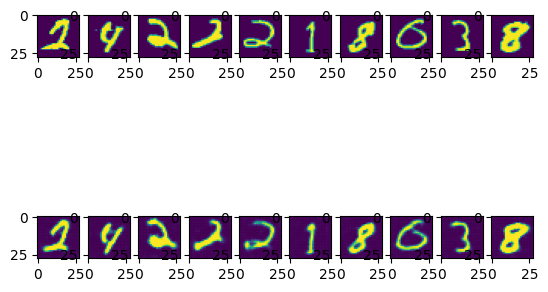

In [43]:
for i in range(10):
  plt.subplot(2, 10, i+1)
  plt.imshow(X.cpu()[i,0,:,:])
  plt.subplot(2,10,i+11)
  plt.imshow(Xhat[i,0,:,:].detach().cpu().numpy())